## Linear Regression With Time Series

From [this time series forecasting course](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series), we will know how to:
* engineer features to model the major time series components (trends, seasons, and cycles)
* visualize time series with many kinds of time series plots
* create forecasting hybrids that combine the strengths of complementary models
* adapt machine learning methods to a variety of forecasting tasks.

### What is a Time Series?
Time series is a set of obeservations recorded over time. 
They are typically recorded with a regular frequency, like daily or monthly.

See the sales of hardcover books with a time index `Date` in last 30 days:

In [1]:
import pandas as pd

df = pd.read_csv(
    "data/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


### Linear Regression
The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:
```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```
Here,
* `weights` also called `regression coefficients`
* `bias` also called `intercept` as it tells where the graph of this function cross the y-axis.


### Types of time series features
There are two kinds of features unique to timer series:
- Time-step features
  * created from time index, or `time dummy` from counts of time steps.
  * sum function: target = weight * lag + bias
  * time dependence: predicts from the time they occured
- Lag features
  * created from shifts of the observations 
  * sum function: target = weight * lag + bias
  * serial dependence: predict from previous observations

The best time series models usually include some combination of time-step features and lag features. 

In this course, we choose linear regressino just for simplicity. You can choose any other algorithms.

### Time-step features
See an example below:

In [2]:
import numpy as np

# numpy.arange([start, ]stop, [step, ]dtype=None, *, like=None)
#  - Return evenly spaced values within a given interval.
df['Time'] = np.arange(stop=len(df.index)) # Time is a time dummy feature

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


In [3]:
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

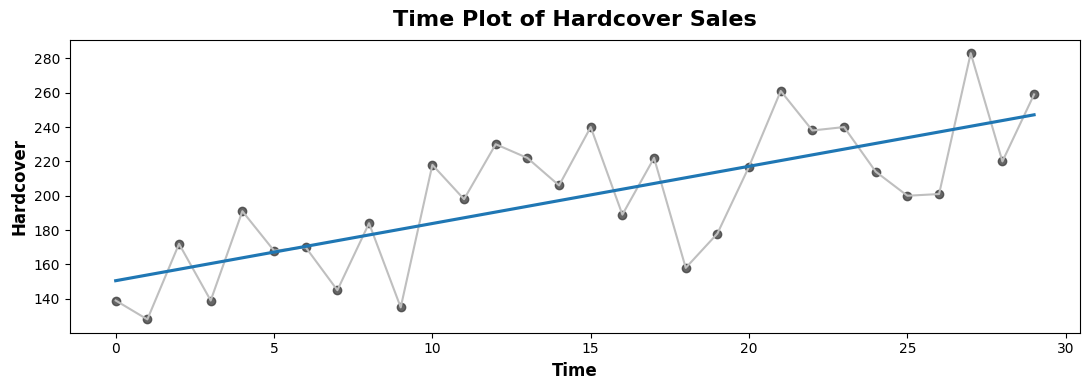

In [4]:
# plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
# %config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

`Time-step` features let you model `time dependence`.

### Lag features
We can shift the observations to make a log feature.
Let's create a 1-step lag feature (*-steps is possible too) now:

In [5]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Let's fit curves to lag plots where each observation in a series is plotted against the previous observation.

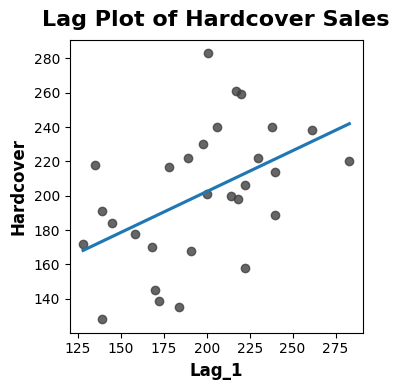

In [6]:
fig, ax = plt.subplots()

ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

The lag plot shown sales on one day(`Hardcover`) are correlated with sales from the previous day(`Lag_1`).
We can predict that high sales on one day usually means high sales on the next day.

### Example - Tunnel Traffic

Let's apply linear regresion to time-step and lag features on vehicles traveling throught a tunnel time series data.

#### Load data

In [7]:
# Load Tunnel Traffic dataset
tunnel = pd.read_csv("data/tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")
print(f"Original index dtype = {tunnel.index.dtype}")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# representing a time series as a sequence of measurements taken at single moments. 
# A `PeriodIndex` on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. That's what we need.

# Convert the DatetimeIndex to a PeriodIndex with daily frequency
tunnel = tunnel.to_period(freq="D")

print(f"Current index dtype = {tunnel.index.dtype}")

tunnel.head()

Original index dtype = datetime64[ns]
Current index dtype = period[D]


,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


#### Time-step feature

In [8]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Build a linear regression model

In [9]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target


In [10]:
# Train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred.head()

Day
2003-11-01    98176.206344
2003-11-02    98198.703794
2003-11-03    98221.201243
2003-11-04    98243.698693
2003-11-05    98266.196142
Freq: D, dtype: float64

The model actually created is (approximately): 
```Vehicles = 22.5 * Time + 98176```.
Plotting the fitted values over time shows the trend line defined by this equation.

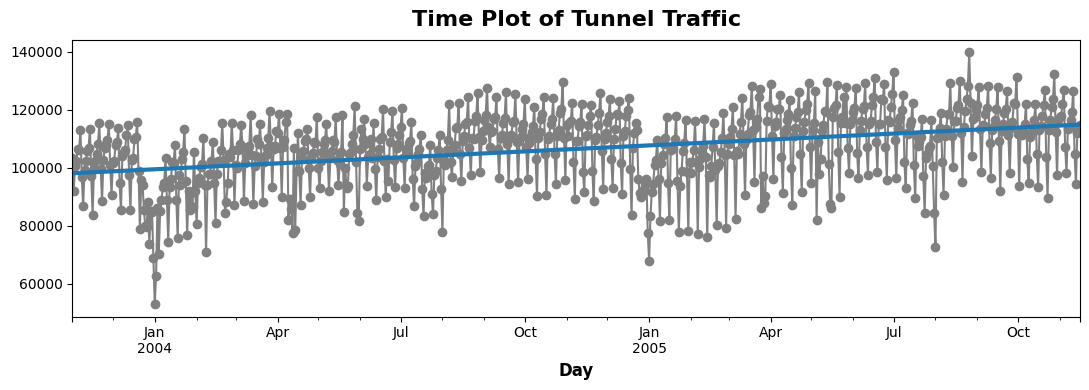

In [12]:
# Define plot_params as a dictionary containing plotting parameters
plot_params = {'kind': 'line', 'color': 'grey', 'marker': 'o'}

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

#### Lag feature

In [13]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [14]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Lag_1']] # lag feature

# drop missing values in the feature set
X.dropna(inplace=True)

# Create target
y = df.loc[:, 'NumVehicles']  

# drop corresponding values in target
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)


The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

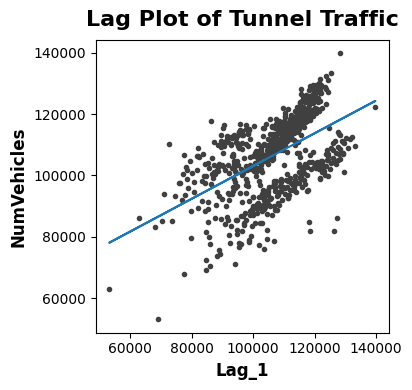

In [15]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

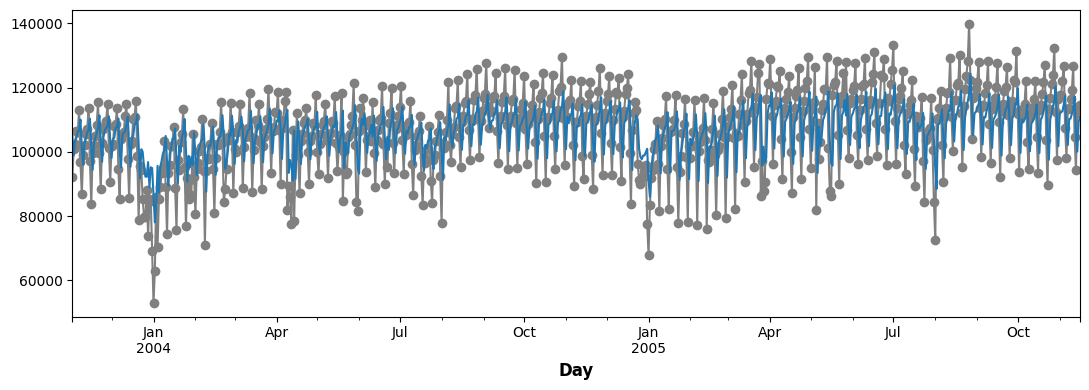

In [16]:
ax = y.plot(**plot_params)
ax = y_pred.plot()